In [1]:
#Import the requried libraries 
!conda install -c conda-forge folium=0.5.0 --yes # uncomment this line if you haven't completed the Foursquare API lab
import folium # map rendering library


from sklearn.cluster import KMeans

# Matplotlib and associated plotting modules
import matplotlib.cm as cm
import matplotlib.colors as colors

#!conda install -c conda-forge geopy --yes # uncomment this line if you haven't completed the Foursquare API lab
from geopy.geocoders import Nominatim # convert an address into latitude and longitude values
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from bs4 import BeautifulSoup

Solving environment: done

## Package Plan ##

  environment location: /opt/conda/envs/Python36

  added / updated specs: 
    - folium=0.5.0


The following packages will be downloaded:

    package                    |            build
    ---------------------------|-----------------
    openssl-1.1.1g             |       h516909a_1         2.1 MB  conda-forge
    vincent-0.4.4              |             py_1          28 KB  conda-forge
    branca-0.4.1               |             py_0          26 KB  conda-forge
    python_abi-3.6             |          1_cp36m           4 KB  conda-forge
    certifi-2020.6.20          |   py36h9f0ad1d_0         151 KB  conda-forge
    ca-certificates-2020.6.20  |       hecda079_0         145 KB  conda-forge
    folium-0.5.0               |             py_0          45 KB  conda-forge
    altair-4.1.0               |             py_1         614 KB  conda-forge
    ------------------------------------------------------------
                       

### Get the neighborhoods data for Mumbai by scraping web data

In [2]:
#Get the data, put it into lists, and clean it
import requests
wiki_data=requests.get('https://en.wikipedia.org/wiki/List_of_neighbourhoods_in_Mumbai').text
#Parse data into a BeautifulSoup object
soup=BeautifulSoup(wiki_data,'html.parser')

#Create lists to store the scraped data
neighborhood = []
location=[]
latitude=[]
longitude=[]

#Get the table for Mumbai by scraping data from the wikipedia page
table=soup.find_all('table')[0]
for rows in table.find_all('tr'):
    cells=rows.find_all('td')
    if len(cells)>0:
        neighborhood.append(cells[0].get_text())
        location.append(cells[1].get_text())
        latitude.append(cells[2].get_text())
        longitude.append(cells[3].get_text())
number_of_rows=len(neighborhood)

#Clean the data 
for rows in range(number_of_rows):
    neighborhood[rows]=neighborhood[rows].rstrip('\n')
    location[rows]=location[rows].rstrip('\n')
    latitude[rows]=float(latitude[rows].rstrip('\n'))
    longitude[rows]=float(longitude[rows].rstrip('\n'))

In [3]:
#Standardize the data 

#Clean the location data
for j in range(len(location)):
    for i in range(len(location[j])):
        if location[j][i+1:i+13]=="South Mumbai":
            location[j]=location[j][i+1:]
            break
        if location[j][i+1:i+16]=="Harbour Suburbs":
            location[j]=location[j][i+1:]
            break
        if location[j][i]==',':
            location[j]=location[j][0:i]
            break
           
#Clean the neighborhood data
for j in range(len(neighborhood)):
    i=0
    while i<len(neighborhood[j]):
        if neighborhood[j][i]==',':
            neighborhood[j]=neighborhood[j][0:i]
            break
        if neighborhood[j][i]=='.':
            neighborhood[j]=neighborhood[j][:i]+neighborhood[j][i+1:]

        i+=1

In [4]:
# Put the data into a pandas dataframe, drop unnecessary values, and get the final neighborhood dataset

df=pd.DataFrame({'Neighborhood':neighborhood,'Location':location,'Latitude':latitude,'Longitude':longitude})

#Remove the data for which latitude and longitude are incorrect
mumbai=df[df.Longitude//1==72].reset_index(drop=True)

#Change the name of some of the neighborhoods to be compatible with property data
old_values=['Khar Danda','Asalfa','Kanjurmarg','Dagdi Chawl','Navy Nagar','Nehru Nagar','Nahur','Deonar','Thakur village']
new_values=['Khar', 'Ghatkopar (East)','Kanjur Marg','Byculla','Colaba','Kurla','Mulund','Govandi','Thakur Village']
mumbai["Neighborhood"]=mumbai["Neighborhood"].replace(old_values,new_values)

#Change the name of some of the locations to standardize them 
old_values=['Borivali (West)','Western Suburbs','Kandivali East']
new_values=['Borivali','Andheri','Kandivali West']
mumbai["Location"]=mumbai["Location"].replace(old_values,new_values)

#Set the index of the dataset to the neighborhood column
mumbai=mumbai.set_index('Neighborhood')

#Change the location for Virar and Dahisar
mumbai.loc[mumbai.index=="Virar", "Location"] = "Vasai"
mumbai.loc[mumbai.index=="Dahisa", "Location"] = "Borivali"

#Drop rows for which property data is not readily available (a lot of them are smaller areas which have property prices similar to surrounding areas)
mumbai=mumbai.drop(['Sahar','Kherwadi','Poisar','Uttan','Irla','Mankhurd','Mahul','Carmichael Road','Cavel','Cotton Green','Cumbala Hill','Currey Road','Dongri','Dhobitalao','Kala Ghoda','Dharavi','Dava Bazaar','Chor Bazaar','Fanas Wadi','Ballard Estate'])

mumbai1= mumbai.sort_values('Location',ascending=True)

In [5]:
print("The different neighborhoods in Mumbai are:")
mumbai1.head()

The different neighborhoods in Mumbai are:


,Location,Latitude,Longitude
Neighborhood,,,
Amboli,Andheri,19.129300,72.843400
Vile Parle,Andheri,19.100000,72.830000
Jogeshwari West,Andheri,19.120000,72.850000
Versova,Andheri,19.120000,72.820000
Seven Bungalows,Andheri,19.129052,72.817018


### Get the data for property prices in Mumbai

In [6]:
import requests
wiki_data=requests.get('https://www.99acres.com/property-rates-and-price-trends-in-mumbai').text
#Parse data into a BeautifulSoup object
soup=BeautifulSoup(wiki_data,'html.parser')

#Create lists to store the scraped data
neighborhood = []
ONE_BHK=[]
TWO_BHK=[]
THREE_BHK=[]

#Scrape the Mumbai properties data table
table=soup.find_all('table')[0]
for rows in table.find_all('tr'):
    cells=rows.find_all('td')
    if len(cells)>0:
        neighborhood.append(str(cells[0].get_text()))
        ONE_BHK.append(str(cells[4].get_text()))
        TWO_BHK.append(str(cells[5].get_text()))
        THREE_BHK.append(str(cells[6].get_text()))

number_of_rows=len(ONE_BHK)

#Clean the Mumbai properties data
for rows in range(number_of_rows):
    ONE_BHK[rows]=ONE_BHK[rows].strip(' ')
    TWO_BHK[rows]=TWO_BHK[rows].strip(' ')
    THREE_BHK[rows]=THREE_BHK[rows].strip(' ')
    if len(ONE_BHK[rows])>1:
        low=ONE_BHK[rows][:-6]
        high=ONE_BHK[rows][-6:]
        low= ''.join(ch for ch in low if ch.isdigit())
        high= ''.join(ch for ch in high if ch.isdigit())
        ONE_BHK[rows]=(float(high)+float(low))/2
    if ONE_BHK[rows]=='-':
        ONE_BHK[rows]=None
    if len(TWO_BHK[rows])>1:
        low=TWO_BHK[rows][:-8]
        high=TWO_BHK[rows][-8:]
        low= ''.join(ch for ch in low if ch.isdigit())
        high= ''.join(ch for ch in high if ch.isdigit())
        TWO_BHK[rows]=(float(high)+float(low))/2
    if TWO_BHK[rows]=='-':
        TWO_BHK[rows]=None
    if len(THREE_BHK[rows])>1:
        low=THREE_BHK[rows][:-8]
        high=THREE_BHK[rows][-8:]
        low= ''.join(ch for ch in low if ch.isdigit())
        high= ''.join(ch for ch in high if ch.isdigit())
        THREE_BHK[rows]=(float(high)+float(low))/2
    if THREE_BHK[rows]=='-':
        THREE_BHK[rows]=None

#Put the data into a pandas dataframe
property_df=pd.DataFrame({'Neighborhood':neighborhood,'1 BHK':ONE_BHK,'2 BHK':TWO_BHK,'3 BHK':THREE_BHK})

#Change the names of some of the datasets to correct spelling mistakes, and make it compatible with the Neighborhood data format
old_values=['4 Bunglows','Seven Bunglow','Band Stand','I C Colony','Juhu Lane','Pali Village','Jogeshwari (West)','Kharegaon','Kharvai','Goregaon (East)']
new_values=['Four Bungalows','Seven Bungalows','Bandstand Promenade','IC Colony','Remove','Pali Naka','Jogeshwari West','Remove','Remove','Dindoshi']
property_df['Neighborhood']=property_df['Neighborhood'].replace(old_values,new_values)

In [7]:
property_df.head()

,Neighborhood,1 BHK,2 BHK,3 BHK
0,Anand Nagar,11921.0,17212.5,NaN
1,Balkum,14292.5,18988.5,27272.0
2,Balkum Pada,12463.0,15854.5,NaN
3,Bhayandarpada,NaN,14131.5,NaN
4,Brahmand,12622.5,18253.5,NaN


Merge the property prices data with Mumbai neighborhoods

In [8]:
for neighborhoods in mumbai.index:
    count=0
    for areas in property_df["Neighborhood"]:
        if neighborhoods in areas:
            property_df["Neighborhood"]=property_df["Neighborhood"].replace(areas,neighborhoods)
            count=1
            break
    if count==1:
        continue
mumbai_properties=pd.merge(mumbai1, property_df, on='Neighborhood')
mumbai_properties=mumbai_properties.set_index("Neighborhood")

#Convert the prices to float type
mumbai_properties["1 BHK"]=mumbai_properties["1 BHK"].astype("float")
mumbai_properties["2 BHK"]=mumbai_properties["2 BHK"].astype("float")
mumbai_properties["3 BHK"]=mumbai_properties["3 BHK"].astype("float")

mumbai_properties = mumbai_properties.loc[~mumbai_properties.index.duplicated(keep='first')]

In [9]:
mumbai_properties.head()

,Location,Latitude,Longitude,1 BHK,2 BHK,3 BHK
Neighborhood,,,,,,
Amboli,Andheri,19.129300,72.843400,NaN,NaN,NaN
Vile Parle,Andheri,19.100000,72.830000,33558.0,51297.5,NaN
Jogeshwari West,Andheri,19.120000,72.850000,23970.0,37952.5,49015.0
Versova,Andheri,19.120000,72.820000,33797.5,51769.5,70987.0
Seven Bungalows,Andheri,19.129052,72.817018,34756.5,49926.5,65747.5


See how many times each location appears in the dataset

In [10]:
mumbai_properties["Location"].value_counts()

South Mumbai       21
Andheri            11
Eastern Suburbs     4
Kandivali West      3
Borivali            3
Ghatkopar           3
Vasai               3
Goregaon            2
Mira-Bhayandar      2
Khar                2
Bandra              2
Powai               2
Malad               2
Harbour Suburbs     2
Sanctacruz          1
Mumbai              1
Mulund              1
Name: Location, dtype: int64

We now replace missing prices 

In [11]:
#Add data to missing 1 BHK values by using corresponding 2 BHK and 3 BHK values
TWO_TO_ONE_BHK_RATIO=(mumbai_properties["2 BHK"]/mumbai_properties["1 BHK"]).mean()
THREE_TO_ONE_BHK_RATIO=(mumbai_properties["3 BHK"]/mumbai_properties["1 BHK"]).mean()
mumbai_properties["1 BHK"]=mumbai_properties["1 BHK"].replace(np.nan,mumbai_properties["2 BHK"]/TWO_TO_ONE_BHK_RATIO)
mumbai_properties["1 BHK"]=mumbai_properties["1 BHK"].replace(np.nan,mumbai_properties["3 BHK"]/THREE_TO_ONE_BHK_RATIO)


#Replace NaN values
TWO_TO_ONE_BHK_RATIO=(mumbai_properties["2 BHK"]/mumbai_properties["1 BHK"]).mean()
THREE_TO_ONE_BHK_RATIO=(mumbai_properties["3 BHK"]/mumbai_properties["1 BHK"]).mean()
mumbai_properties["2 BHK"]=mumbai_properties["2 BHK"].replace(np.nan,mumbai_properties["1 BHK"]*TWO_TO_ONE_BHK_RATIO)
mumbai_properties["3 BHK"]=mumbai_properties["3 BHK"].replace(np.nan,mumbai_properties["1 BHK"]*THREE_TO_ONE_BHK_RATIO)

#Get the average property price for each location
average_location_prices=mumbai_properties.groupby('Location').mean()

#Replace NaN values
TWO_TO_ONE_BHK_RATIO=(mumbai_properties["2 BHK"]/mumbai_properties["1 BHK"]).mean()
THREE_TO_ONE_BHK_RATIO=(mumbai_properties["3 BHK"]/mumbai_properties["1 BHK"]).mean()
average_location_prices["2 BHK"]=average_location_prices["2 BHK"].replace(np.nan,average_location_prices["1 BHK"]*TWO_TO_ONE_BHK_RATIO)
average_location_prices["3 BHK"]=average_location_prices["3 BHK"].replace(np.nan,average_location_prices["1 BHK"]*THREE_TO_ONE_BHK_RATIO)

#Rename columns
average_location_prices=average_location_prices.rename(columns={"1 BHK":"1 BHK Location Average","2 BHK":"2 BHK Location Average","3 BHK":"3 BHK Location Average"})

#Drop columns
average_location_prices=average_location_prices.drop(columns=["Latitude","Longitude"])

In [12]:
print("These are the average location prices")
average_location_prices

These are the average location prices


,1 BHK Location Average,2 BHK Location Average,3 BHK Location Average
Location,,,
Andheri,30786.650000,49194.215259,74945.481401
Bandra,51212.500000,79212.231584,133063.855196
Borivali,14848.500000,22684.067608,34664.736824
Eastern Suburbs,25281.833333,43622.000000,56455.333333
Ghatkopar,24556.914724,40959.250000,65394.128490
Goregaon,18806.261515,29281.500000,40966.629037
Harbour Suburbs,23789.000000,37572.462291,58930.298192
Kandivali West,18704.000000,29220.333333,38550.166667
Khar,45245.500000,78622.982105,122498.538368


The average location prices dataset is merged with the property prices.The NaN values are replaced with the average value for the corresponding category 

In [13]:
#merge the average dataset with the properties dataset
mumbai_properties_final=pd.merge(mumbai_properties,average_location_prices,on='Location')

#Convert all NaN values to location averages 
mumbai_properties_final["1 BHK"]=mumbai_properties_final["1 BHK"].replace(np.nan,mumbai_properties_final["1 BHK Location Average"])
mumbai_properties_final["2 BHK"]=mumbai_properties_final["2 BHK"].replace(np.nan,mumbai_properties_final["2 BHK Location Average"])
mumbai_properties_final["3 BHK"]=mumbai_properties_final["3 BHK"].replace(np.nan,mumbai_properties_final["3 BHK Location Average"])

#Add neighborhoods column
mumbai_properties_final["Neighborhood"]=mumbai_properties.index


In [14]:
print("This is the final Mumbai properties dataset")

#Let's move neighborhoods to the first column
loc=mumbai_properties_final.columns.get_loc("Neighborhood")
fixed_columns = [mumbai_properties_final.columns[loc]] + list(mumbai_properties_final.columns[0:loc])
mumbai_properties_final=mumbai_properties_final[fixed_columns]

#Let's also drop other unnecessary columns
mumbai_properties_final.drop(columns=["1 BHK Location Average","2 BHK Location Average","3 BHK Location Average"],inplace=True)
mumbai_properties_final.head()

This is the final Mumbai properties dataset


,Neighborhood,Location,Latitude,Longitude,1 BHK,2 BHK,3 BHK
0,Amboli,Andheri,19.129300,72.843400,30786.65,49194.215259,74945.481401
1,Vile Parle,Andheri,19.100000,72.830000,33558.00,51297.500000,89363.675711
2,Jogeshwari West,Andheri,19.120000,72.850000,23970.00,37952.500000,49015.000000
3,Versova,Andheri,19.120000,72.820000,33797.50,51769.500000,70987.000000
4,Seven Bungalows,Andheri,19.129052,72.817018,34756.50,49926.500000,65747.500000


### Using Foursquare to get venues data 

In [15]:
CLIENT_ID = 'OC4QCCJI4ITBBFWO0FGGHWTDTJXNO34KBX44MS3VD5PEG1IT' # your Foursquare ID
CLIENT_SECRET = 'BXZUJOPBRVYL4BXB2VV0QFI1LE3BTHCC2PYUACPKGTU4CYSG' # your Foursquare Secret
VERSION = '20180605' # Foursquare API version

print('Your credentails:')
print('CLIENT_ID: ' + CLIENT_ID)
print('CLIENT_SECRET:' + CLIENT_SECRET)

Your credentails:
CLIENT_ID: OC4QCCJI4ITBBFWO0FGGHWTDTJXNO34KBX44MS3VD5PEG1IT
CLIENT_SECRET:BXZUJOPBRVYL4BXB2VV0QFI1LE3BTHCC2PYUACPKGTU4CYSG


#### Let's explore Juhu

In [16]:
neighborhood_latitude = mumbai_properties_final.loc[5, 'Latitude'] # neighborhood latitude value
neighborhood_longitude = mumbai_properties_final.loc[5, 'Longitude'] # neighborhood longitude value

neighborhood_name = mumbai_properties_final.loc[5, 'Neighborhood'] # neighborhood name

print('Latitude and longitude values of {} are {}, {}.'.format(neighborhood_name, 
                                                               neighborhood_latitude, 
                                                               neighborhood_longitude))

Latitude and longitude values of Juhu are 19.1, 72.83.


In [17]:
LIMIT = 300 # limit of number of venues returned by Foursquare API
radius = 1500 # define radius
# create URL
url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
    CLIENT_ID, 
    CLIENT_SECRET, 
    VERSION, 
    neighborhood_latitude, 
    neighborhood_longitude, 
    radius, 
    LIMIT)
url # display URL

'https://api.foursquare.com/v2/venues/explore?&client_id=OC4QCCJI4ITBBFWO0FGGHWTDTJXNO34KBX44MS3VD5PEG1IT&client_secret=BXZUJOPBRVYL4BXB2VV0QFI1LE3BTHCC2PYUACPKGTU4CYSG&v=20180605&ll=19.1,72.83&radius=1500&limit=300'

In [18]:
# function that extracts the category of the venue
def get_category_type(row):
    try:
        categories_list = row['categories']
    except:
        categories_list = row['venue.categories']
        
    if len(categories_list) == 0:
        return None
    else:
        return categories_list[0]['name']

In [19]:
results = requests.get(url).json()['response']['groups'][0]['items']
from pandas.io.json import json_normalize
nearby_venues = json_normalize(results) # flatten JSON
# filter columns
filtered_columns = ['venue.name', 'venue.categories', 'venue.location.lat', 'venue.location.lng']
nearby_venues =nearby_venues.loc[:, filtered_columns]

# filter the category for each row
nearby_venues['venue.categories'] = nearby_venues.apply(get_category_type, axis=1)

# clean columns
nearby_venues.columns = [col.split(".")[-1] for col in nearby_venues.columns]

nearby_venues.head()

,name,categories,lat,lng
0,Starbucks,Coffee Shop,19.100479,72.827438
1,Soho House,Club House,19.095805,72.829070
2,JW Marriott Mumbai Juhu,Hotel,19.102037,72.826181
3,Mahesh Lunch Home,Seafood Restaurant,19.103680,72.826794
4,Smooch Italian Frozen Yogurt,Dessert Shop,19.096430,72.827640


In [20]:
print('{} venues were returned by Foursquare.'.format(nearby_venues.shape[0]))

100 venues were returned by Foursquare.


### We have only explored one neighborhood so far. Let's repeat the process for all neighborhoods for the dataset below
### Let's create a function that does the above procedure. We can repeatedly call the function for all our neighborhoods

In [21]:
def getNearbyVenues(names, latitudes, longitudes, radius):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        print(name)
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])
        
        
    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighborhood', 
                  'Neighborhood Latitude', 
                  'Neighborhood Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

In [22]:
mumbai_venues = getNearbyVenues(names=mumbai_properties_final['Neighborhood'],
                                   latitudes=mumbai_properties_final['Latitude'],
                                   longitudes=mumbai_properties_final['Longitude'],
                                   radius=2000
                                  )

Amboli
Vile Parle
Jogeshwari West
Versova
Seven Bungalows
Juhu
Lokhandwala
Four Bungalows
DN Nagar
Chakala
Marol
Bandstand Promenade
Pali Hill
IC Colony
Gorai
Dahisa
Vikhroli
Bhandup
Vidyavihar
Kanjur Marg
Pant Nagar
Ghatkopar (East)
Amrut Nagar
Aarey Milk Colony
Bangur Nagar
Chembur
Govandi
Mahavir Nagar
Thakur Village
Charkop
Khar
Pali Naka
Sunder Nagar
Dindoshi
Bhayandar
Mira Road
Mulund
Thane
Hiranandani Gardens
Chandivali
Kalina
Parel
Matunga
Colaba
Byculla
Marine Lines
Worli
Walkeshwar
Sion
Prabhadevi
Mumbai Central
Malabar Hill
Mahim
Mahalaxmi
Kemps Corner
Cuffe Parade
Churchgate
Breach Candy
Agripada
Gowalia Tank
Marine Drive
Altamount Road
Naigaon
Nalasopara
Virar


Lets' check the size of the dataframe

In [23]:
print(mumbai_venues.shape)
mumbai_venues.head()

(4914, 7)


,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,Amboli,19.1293,72.8434,Shawarma Factory,19.124591,72.840398,Falafel Restaurant
1,Amboli,19.1293,72.8434,Merwans Cake shop,19.119300,72.845418,Bakery
2,Amboli,19.1293,72.8434,Hard Rock Cafe Andheri,19.135995,72.835335,American Restaurant
3,Amboli,19.1293,72.8434,Jaffer Bhai's Delhi Darbar,19.137714,72.845909,Mughlai Restaurant
4,Amboli,19.1293,72.8434,Pizza Express,19.131893,72.834668,Pizza Place


Let's see how many venues each neighborhood returned 

In [24]:
grouped=mumbai_venues.groupby("Neighborhood").count()
count=grouped["Venue"]
print(grouped)

                     Neighborhood Latitude  Neighborhood Longitude  Venue  \
Neighborhood                                                                
Aarey Milk Colony                       16                      16     16   
Agripada                               100                     100    100   
Altamount Road                          97                      97     97   
Amboli                                  90                      90     90   
Amrut Nagar                            100                     100    100   
Bandstand Promenade                     77                      77     77   
Bangur Nagar                           100                     100    100   
Bhandup                                 27                      27     27   
Bhayandar                               29                      29     29   
Breach Candy                           100                     100    100   
Byculla                                100                     100    100   

Let's add the number of venues for each neighborhood to our mumbai_properties_final dataframe

In [25]:
mumbai_properties_final=pd.merge(mumbai_properties_final,count,on="Neighborhood")

It doesn't make a lot of sense to consider neighborhoods that returned less than 20 venues for a 2km radius. Let's drop these neighborhoods.

In [26]:
mumbai_properties_final.drop(mumbai_properties_final[ mumbai_properties_final['Venue'] < 20 ].index , inplace=True)


Let's get the venues in a 1km radius for all neighborhoods we will be including 

In [27]:
mumbai_venues = getNearbyVenues(names=mumbai_properties_final["Neighborhood"],
                                   latitudes=mumbai_properties_final['Latitude'],
                                   longitudes=mumbai_properties_final['Longitude'],
                                    radius=1000
                                  )

Amboli
Vile Parle
Jogeshwari West
Versova
Seven Bungalows
Juhu
Lokhandwala
Four Bungalows
DN Nagar
Chakala
Marol
Bandstand Promenade
Pali Hill
IC Colony
Dahisa
Bhandup
Vidyavihar
Kanjur Marg
Pant Nagar
Ghatkopar (East)
Amrut Nagar
Bangur Nagar
Chembur
Govandi
Mahavir Nagar
Thakur Village
Charkop
Khar
Pali Naka
Sunder Nagar
Dindoshi
Bhayandar
Mira Road
Mulund
Thane
Hiranandani Gardens
Chandivali
Kalina
Parel
Matunga
Byculla
Marine Lines
Worli
Walkeshwar
Sion
Prabhadevi
Mumbai Central
Malabar Hill
Mahim
Mahalaxmi
Kemps Corner
Cuffe Parade
Churchgate
Breach Candy
Agripada
Gowalia Tank
Marine Drive
Altamount Road


Let's clean the venues dataset 
1. Combine similar venue categories (e.g. Punjabi restaurant, North Indian restaurant can be combined with Indian Restaurant). 
2. Remove venue categories which have very few venues across the city.

In [28]:
#Combine categories
old_values=['Dim Sum Restaurant', 'Tex-Mex Restaurant','Dumpling Restaurant','North Indian Restaurant','Burrito Place','Multicuisine Indian Restaurant','Bagel Shop','Spanish Restaurant','Bar','Greek Restaurant','Cheese Shop','Mughlai Restaurant','New American Restaurant','Frozen Yogurt Shop','Sushi Restaurant' ,'French Restaurant','Athletics & Sports','Maharashtrian Restaurant','Punjabi Restaurant','Sports Bar','Market','Falafel Restaurant','Playground','Cupcake Shop','Thai Restaurant','Garden',"Cocktail Bar",'Movie Theater','Salad Place','Food Truck','Gastropub','Convenience Store','Gym','Department Store','Dessert Shop','Sandwich Place','Snack Place','Café','Diner']
new_values=['Chinese Restaurant','Mexican Restaurant','Chinese Restaurant','Indian Restaurant','Mexican Restaurant ','Indian Restaurant','Bakery','Mexican Restaurant','Pub','Mediterranean Restaurant','Bakery','Indian Restaurant','American Restaurant','Ice Cream Shop','Japanese Restaurant','Modern European Restaurant','Gym / Fitness Center','Indian Restaurant','Indian Restaurant','Pub','Grocery Store','Middle Eastern Restaurant','Park','Bakery','Asian Restaurant','Park','Pub','Multiplex','Juice Bar','Snack Place','Pub','Grocery Store','Gym / Fitness Center','Shopping Mall','Bakery','Fast Food Restaurant','Fast Food Restaurant','Restaurant','Restaurant']
mumbai_venues["Venue Category"].replace(old_values,new_values,inplace=True)

#See how many different venues for each category exist 
count=mumbai_venues["Venue Category"].value_counts().rename_axis('Venue Category').reset_index(name='Count')

#Add the number of venues for each venue category to the dataset
mumbai_venues1=pd.merge(mumbai_venues,count,on='Venue Category')

#Remove categories which have very few venues across the city
mumbai_venues1.drop(mumbai_venues1[mumbai_venues1["Count"]<=16].index,inplace=True)
mumbai_venues1.drop(mumbai_venues1[mumbai_venues1["Venue Category"].isin(['Hotel Bar','Women\'s Store','Scenic Lookout'])].index,inplace=True)

In [29]:
#Let's assign a dummy value for each category in Venue Category so that if we can check if a neighborhood contains a Venue Category

# one hot encoding
mumbai_onehot = pd.get_dummies(mumbai_venues1[['Venue Category']], prefix="", prefix_sep="")
mumbai_onehot['Neighborhood'] = mumbai_venues1['Neighborhood'] 

mumbai_venues_grouped = mumbai_onehot.groupby('Neighborhood').mean().reset_index()

#Assign a 1 if present, 0 if not
for columns in mumbai_venues_grouped.columns[1:]:
    mumbai_venues_grouped.loc[mumbai_venues_grouped[columns] >0, columns] = 1

### We finally have the 3 datasets we will be using 

### This is the dataset for property prices for renting 1 BHK, 2BHK, 3 BHK in different neighborhoods of Mumbai 

In [30]:
#mumbai_properties_final.drop(columns='Venue',inplace=True)
mumbai_properties_final

,Neighborhood,Location,Latitude,Longitude,1 BHK,2 BHK,3 BHK,Venue
0,Amboli,Andheri,19.129300,72.843400,30786.650000,49194.215259,74945.481401,90
1,Vile Parle,Andheri,19.100000,72.830000,33558.000000,51297.500000,89363.675711,100
2,Jogeshwari West,Andheri,19.120000,72.850000,23970.000000,37952.500000,49015.000000,87
3,Versova,Andheri,19.120000,72.820000,33797.500000,51769.500000,70987.000000,100
4,Seven Bungalows,Andheri,19.129052,72.817018,34756.500000,49926.500000,65747.500000,100
5,Juhu,Andheri,19.100000,72.830000,43248.000000,73886.000000,133960.000000,100
6,Lokhandwala,Andheri,19.130815,72.829270,35445.000000,50065.000000,74906.000000,100
7,Four Bungalows,Andheri,19.124714,72.827210,30621.500000,54400.000000,81543.888068,100
8,DN Nagar,Andheri,19.124085,72.831373,24437.500000,41647.652589,74013.500000,100
9,Chakala,Andheri,19.111388,72.860833,20851.500000,43920.000000,55526.750226,100


### These are all the different venues found in a neighborhood in a 1km radius

In [31]:
mumbai_venues1

,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category,Count
12,Amboli,19.129300,72.843400,Cafe Arfa,19.128930,72.847140,Indian Restaurant,297
13,Amboli,19.129300,72.843400,Jaffer Bhai's Delhi Darbar,19.137714,72.845909,Indian Restaurant,297
14,Amboli,19.129300,72.843400,Garden Court,19.127188,72.837478,Indian Restaurant,297
15,Amboli,19.129300,72.843400,Persia Darbar,19.136952,72.846822,Indian Restaurant,297
16,Amboli,19.129300,72.843400,Sarvodaya Veg. Restaurant,19.123760,72.850893,Indian Restaurant,297
17,Amboli,19.129300,72.843400,Northern Tadka,19.131929,72.834948,Indian Restaurant,297
18,Amboli,19.129300,72.843400,Mauja,19.127157,72.835211,Indian Restaurant,297
19,Vile Parle,19.100000,72.830000,Lotus Café,19.101772,72.825664,Indian Restaurant,297
20,Vile Parle,19.100000,72.830000,Shiv Sagar,19.098715,72.827614,Indian Restaurant,297
21,Vile Parle,19.100000,72.830000,maharaja bhog,19.096471,72.828044,Indian Restaurant,297


### This dataset shows if a certain venue category is present in a neighborhood or not

In [32]:
mumbai_venues_grouped

,Neighborhood,Asian Restaurant,Bakery,Chinese Restaurant,Clothing Store,Coffee Shop,Donut Shop,Electronics Store,Fast Food Restaurant,Grocery Store,...,Multiplex,Park,Pizza Place,Pub,Restaurant,Seafood Restaurant,Shopping Mall,Snack Place,Spa,Vegetarian / Vegan Restaurant
0,Agripada,1.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,...,1.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0
1,Altamount Road,0.0,1.0,1.0,0.0,1.0,1.0,1.0,1.0,0.0,...,0.0,1.0,1.0,1.0,1.0,0.0,1.0,1.0,1.0,1.0
2,Amboli,1.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,...,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0
3,Amrut Nagar,1.0,0.0,1.0,1.0,1.0,0.0,1.0,1.0,0.0,...,1.0,0.0,1.0,1.0,1.0,0.0,1.0,0.0,0.0,1.0
4,Bandstand Promenade,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0
5,Bangur Nagar,0.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,0.0,...,1.0,0.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,1.0
6,Bhandup,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,...,1.0,0.0,1.0,1.0,1.0,0.0,1.0,0.0,0.0,1.0
7,Bhayandar,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,...,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0
8,Breach Candy,0.0,1.0,1.0,0.0,1.0,1.0,0.0,1.0,0.0,...,0.0,1.0,1.0,1.0,1.0,0.0,1.0,0.0,0.0,1.0
9,Byculla,1.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,...,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0


In [33]:
print("The number of unique venue categories are:",len(mumbai_venues1["Venue Category"].value_counts()))

The number of unique venue categories are: 27


In [34]:
print("Number of venues in each neighborhood are\n",(mumbai_venues1["Neighborhood"].value_counts()))

Number of venues in each neighborhood are
 Lokhandwala            76
Pali Naka              73
Pali Hill              71
Thane                  68
Juhu                   66
Vile Parle             66
Hiranandani Gardens    66
Altamount Road         65
Gowalia Tank           62
Churchgate             61
Sunder Nagar           56
Seven Bungalows        51
Matunga                48
Four Bungalows         45
Breach Candy           44
Khar                   44
Kemps Corner           43
Chembur                41
DN Nagar               41
Pant Nagar             40
Amrut Nagar            40
Chakala                38
Mahim                  35
Dindoshi               35
Thakur Village         32
Vidyavihar             32
Marine Lines           31
Kalina                 30
Amboli                 30
Bangur Nagar           29
Versova                29
Mumbai Central         27
Prabhadevi             27
Marine Drive           27
Sion                   26
Worli                  25
Mira Road            

#### Let's graphically explore the property prices for different neighborhoods

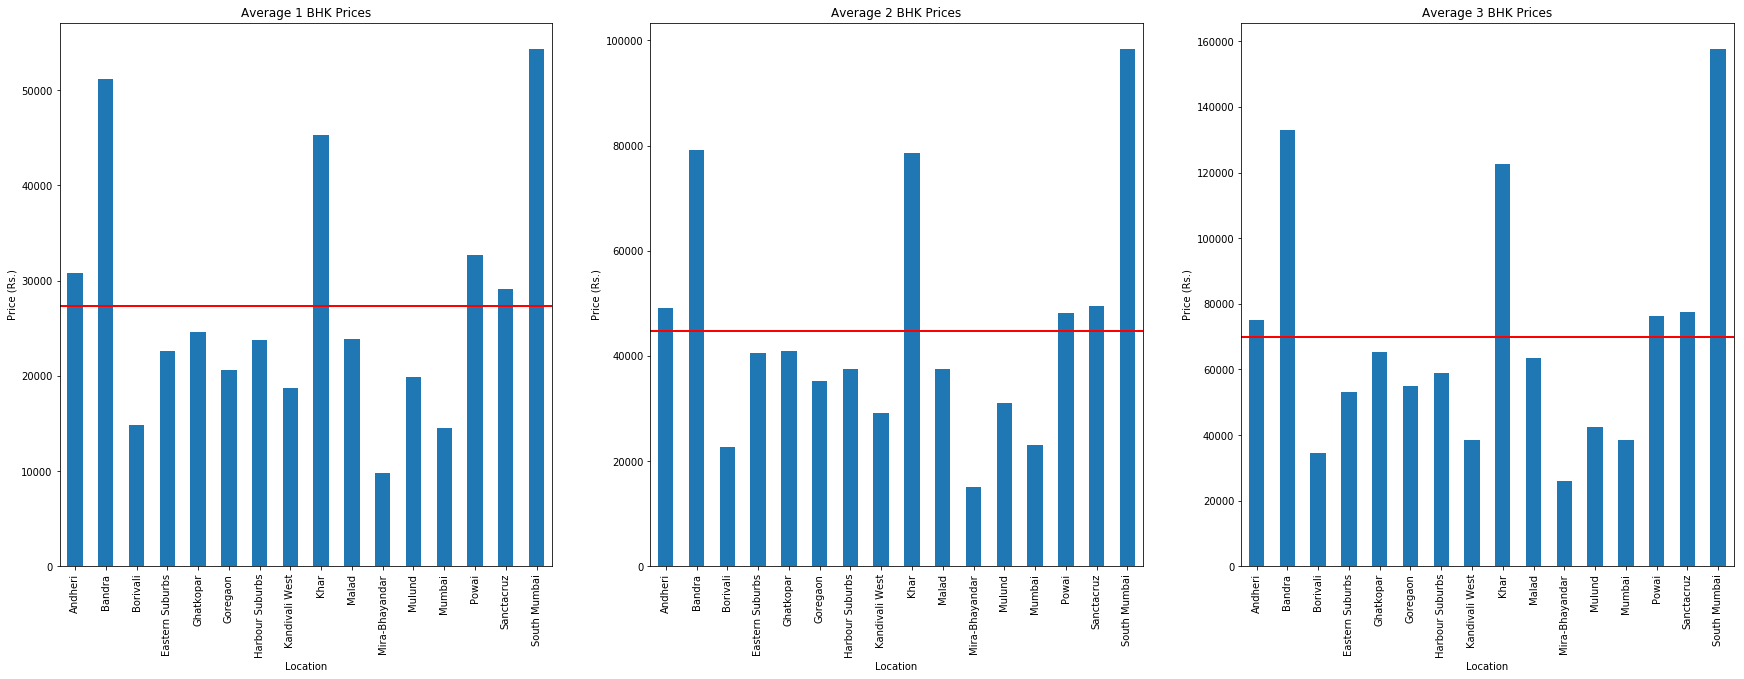

In [36]:
fig=plt.figure()
ax0 = fig.add_subplot(1, 3, 1) 
ax1 = fig.add_subplot(1, 3, 2) 
ax2 = fig.add_subplot(1, 3, 3) 
average_location_price=mumbai_properties_final.groupby('Location').mean()
average_location_price.drop(columns=['Latitude','Longitude'],inplace=True)
ONE_BHK=average_location_price["1 BHK"]
ONE_BHK.plot(kind ='bar',figsize=(20,6), ax=ax0
        )

ax0.set_title('Average 1 BHK Prices')
ax0.set_ylabel('Price (Rs.)')
ax0.set_xlabel('Location')
ax0.axhline(ONE_BHK.mean(), color='red', linewidth=2)

TWO_BHK=average_location_price["2 BHK"]
TWO_BHK.plot(kind ='bar',figsize=(20,6), ax=ax1
        )

ax1.set_title('Average 2 BHK Prices')
ax1.set_ylabel('Price (Rs.)')
ax1.set_xlabel('Location')
ax1.axhline(TWO_BHK.mean(), color='red', linewidth=2)

THREE_BHK=average_location_price["3 BHK"]
THREE_BHK.plot(kind ='bar',figsize=(30,10), ax=ax2
        )

ax2.set_title('Average 3 BHK Prices')
ax2.set_ylabel('Price (Rs.)')
ax2.set_xlabel('Location')
ax2.axhline(THREE_BHK.mean(), color='red', linewidth=2)
plt.show()

#### Let's graphically explore the different venue categories as returned by Foursquare

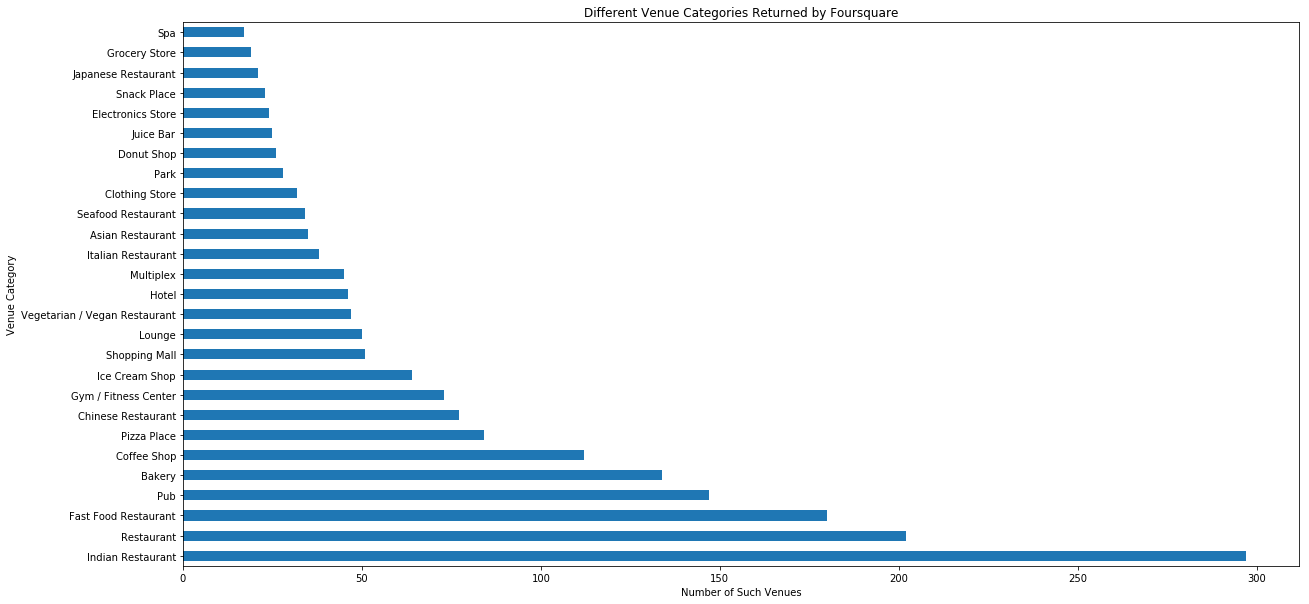

In [37]:
each_type=mumbai_venues1["Venue Category"].value_counts()
each_type.plot(kind ='barh',figsize=(20,10)
        )
plt.title("Different Venue Categories Returned by Foursquare")
plt.xlabel('Number of Such Venues')
plt.ylabel('Venue Category')
plt.show()

#### Let's see all the neighborhoods we are considering on a map

In [55]:
address = 'Mumbai'

geolocator = Nominatim(user_agent="ON")
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude
print('The geograpical coordinate of Mumbai are {}, {}.'.format(latitude, longitude))

# create map of Mumbai using latitude and longitude values
map_mumbai = folium.Map(location=[latitude, longitude], zoom_start=10)

# add markers to map
for lat, lng, location, neighborhood in zip(mumbai_properties_final['Latitude'], mumbai_properties_final['Longitude'], mumbai_properties_final['Location'], mumbai_properties_final["Neighborhood"]):
    label = '{}, {}'.format(neighborhood, location)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_mumbai)  

print("The following is a map of Mumbai with a marker placed on each neighborhood")

map_mumbai.save('map.png')
map_mumbai

The geograpical coordinate of Mumbai are 19.0759899, 72.8773928.
The following is a map of Mumbai with a marker placed on each neighborhood


### User will now input what kind of flat they are looking to rent 

In [39]:
property_type=input("What kind of flat do you want to rent: Enter 1 for 1 BHK, 2 for 2 BHK, 3 for 3 BHK:")
property_type+=' BHK'
print("Price range for 1 BHK apartments in Mumbai= Rs.",mumbai_properties_final[property_type].min(),'- Rs.',mumbai_properties_final[property_type].max())

What kind of flat do you want to rent: Enter 1 for 1 BHK, 2 for 2 BHK, 3 for 3 BHK:2
Price range for 1 BHK apartments in Mumbai= Rs. 14131.5 - Rs. 158107.72390830112


### User will now input their budget
A recommendation will be provided for neighborhoods the user can consider

In [40]:
price_range=float(input("What is your budget? "))

What is your budget? 85000


### These are the neighborhoods you can consider looking for an apartment in based on your budget

In [47]:
options=mumbai_properties_final[(mumbai_properties_final[property_type]<=1.25*price_range) & (mumbai_properties_final[property_type]>=0.75*price_range)]
print(options[['Neighborhood','Location',property_type]])

           Neighborhood      Location         2 BHK
5                  Juhu       Andheri  73886.000000
11  Bandstand Promenade        Bandra  78949.463168
12            Pali Hill        Bandra  79475.000000
30                 Khar          Khar  77775.000000
31            Pali Naka          Khar  79470.964209
41                Parel  South Mumbai  76834.000000
42              Matunga  South Mumbai  67955.000000
45         Marine Lines  South Mumbai  97792.993401
47           Walkeshwar  South Mumbai  97792.993401
49           Prabhadevi  South Mumbai  77867.000000
50       Mumbai Central  South Mumbai  80325.000000
53            Mahalaxmi  South Mumbai  99520.000000
54         Kemps Corner  South Mumbai  97792.993401
58             Agripada  South Mumbai  97792.993401
59         Gowalia Tank  South Mumbai  97792.993401
60         Marine Drive  South Mumbai  97792.993401


In [48]:
venue_options=mumbai_venues1[mumbai_venues1["Neighborhood"].isin(options["Neighborhood"])]

### We all want to live in a neighborhood where we have access to places we visit frequently- below is a compiled list of venues available in the neighborhoods in your budget range. Select from the list below some of the venues that you would like to have in your neighborhood and we can provide you with a more personalized recommendation.
\* The venues list is taken from data available on FourSqaure and should not be taken as an exhaustive list of venues

In [49]:
venue_options["Venue Category"].value_counts()

Indian Restaurant                94
Restaurant                       68
Bakery                           65
Fast Food Restaurant             52
Pub                              38
Coffee Shop                      29
Chinese Restaurant               23
Lounge                           17
Pizza Place                      16
Ice Cream Shop                   16
Hotel                            14
Gym / Fitness Center             14
Seafood Restaurant               13
Italian Restaurant               12
Asian Restaurant                 11
Juice Bar                        10
Multiplex                         9
Shopping Mall                     9
Snack Place                       9
Park                              8
Spa                               8
Japanese Restaurant               8
Clothing Store                    7
Grocery Store                     6
Vegetarian / Vegan Restaurant     6
Electronics Store                 5
Donut Shop                        4
Name: Venue Category, dtype:

In [44]:
venues_desired=[]
number_of_venues_desired=int(input("How many venues do you desire:"))
for i in range(number_of_venues_desired):
    venues_desired.append(input())
venues_desired

How many venues do you desire:2
Ice Cream Shop
Coffee Shop


['Ice Cream Shop', 'Coffee Shop']

### These are the neighborhoods which fall within your budget and have the venues you desire

In [52]:
mumbai_venues_desired=mumbai_venues_grouped.copy()
for i in venues_desired:
    mumbai_venues_desired.drop(mumbai_venues_desired[mumbai_venues_desired[i]==float(0)].index,inplace=True)
options[options["Neighborhood"].isin(mumbai_venues_desired['Neighborhood'])][['Neighborhood','Location',property_type]]

These are the neighborhoods which fall within your budget and have the venues you desire


,Neighborhood,Location,2 BHK
5,Juhu,Andheri,73886.000000
11,Bandstand Promenade,Bandra,78949.463168
12,Pali Hill,Bandra,79475.000000
30,Khar,Khar,77775.000000
42,Matunga,South Mumbai,67955.000000
45,Marine Lines,South Mumbai,97792.993401
47,Walkeshwar,South Mumbai,97792.993401
50,Mumbai Central,South Mumbai,80325.000000
54,Kemps Corner,South Mumbai,97792.993401
59,Gowalia Tank,South Mumbai,97792.993401
